In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import datetime

from src.poly_reg import model_county
from src.poly_reg import model_state
from src.data_import import extract_nyt
import src.data_import as di

plt.style.use('ggplot')
font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [22]:
nyt_df = di.extract_nyt()

In [23]:
nyt_df

,date,county,state,fips,cases,deaths,sc
0,2020-01-21,Snohomish,Washington,53061.0,1,0,Washington:Snohomish
1,2020-01-22,Snohomish,Washington,53061.0,1,0,Washington:Snohomish
2,2020-01-23,Snohomish,Washington,53061.0,1,0,Washington:Snohomish
3,2020-01-24,Cook,Illinois,17031.0,1,0,Illinois:Cook
4,2020-01-24,Snohomish,Washington,53061.0,1,0,Washington:Snohomish
...,...,...,...,...,...,...,...
38192,2020-04-06,Sublette,Wyoming,56035.0,1,0,Wyoming:Sublette
38193,2020-04-06,Sweetwater,Wyoming,56037.0,5,0,Wyoming:Sweetwater
38194,2020-04-06,Teton,Wyoming,56039.0,40,0,Wyoming:Teton
38195,2020-04-06,Uinta,Wyoming,56041.0,3,0,Wyoming:Uinta


In [42]:
hhi_df = di.extract_hhi()

In [46]:
pt_df = di.extract_public_transport()

In [47]:
pt_df

,sc,percent_commuter
0,Alabama:Shelby,0.0
1,Alabama:Talladega,N
2,Alabama:Tuscaloosa,0.2
3,Arizona:Pinal,0.2
4,California:Mendocino,0.0
...,...,...
833,California:Butte,1.2
834,California:El,1.9
835,California:Imperial,1.3
836,California:Kern,0.9


In [44]:
edu_df = di.extract_edu()

In [45]:
edu_df

,sc,pop_over_25,hs,ba_plus,ma_plus,pop_over_65
0,Alabama:Shelby,149389,19.3,26.9,13.8,33295
1,Alabama:Talladega,56275,34.8,9.2,5.5,14422
2,Alabama:Tuscaloosa,130662,31.2,17.7,12.2,27472
3,Arizona:Pinal,309013,29.3,12.3,7.4,90825
4,California:Mendocino,61385,25.3,14.9,8.8,19072
...,...,...,...,...,...,...
833,California:Butte,152912,22.6,17.3,8.9,42820
834,California:El,138848,20.2,23.3,12.6,40427
835,California:Imperial,111825,25.5,9.5,4.6,23512
836,California:Kern,547240,26.8,10.4,5.8,98076


In [48]:
housing_df = di.extract_housing()

In [49]:
housing_df

,sc,median_house_price,median_rent,percent_big_buildings
0,Alabama:Morgan,139700,710,3.7
1,California:Kings,231100,1083,5.2
2,California:Monterey,563000,1511,6.0
3,California:Nevada,456000,1256,2.5
4,California:Shasta,265000,1084,2.7
...,...,...,...,...
833,Wisconsin:Racine,187300,847,7.4
834,Puerto Rico:Bayamón,128100,558,5.5
835,Puerto Rico:Ponce,101200,416,5.8
836,Puerto Rico:Toa,130900,612,N


In [50]:
politics_df = di.extract_election()

In [73]:
airports_df = di.extract_airports()

In [52]:
counties_df = di.extract_geography()

In [74]:
air_travel_df = di.build_intl_arrivals_index_df(counties_df, airports_df, 100)

In [75]:
air_travel_df[air_travel_df['international']>0]

,sc,international,domestic,airports
69,Alaska:Anchorage,38383.0,2512902.0,"[Anchorage, AK (ANC)]"
103,Arizona:Maricopa,1022695.0,20574818.0,"[Phoenix, AZ (PHX)]"
106,Arizona:Pima,2393.0,1685121.0,"[Tucson, AZ (TUS)]"
107,Arizona:Pinal,1025088.0,22259939.0,"[Phoenix, AZ (PHX), Tucson, AZ (TUS)]"
108,Arizona:Santa Cruz,2393.0,1685121.0,"[Tucson, AZ (TUS)]"
...,...,...,...,...
3103,Wisconsin:St. Croix,1453112.0,17025649.0,"[Minneapolis, MN (MSP)]"
3107,Wisconsin:Sheboygan,66751.0,3421109.0,"[Milwaukee, WI (MKE)]"
3112,Wisconsin:Walworth,6463618.0,35747736.0,"[Chicago, IL (ORD), Milwaukee, WI (MKE)]"
3114,Wisconsin:Washington,66751.0,3421109.0,"[Milwaukee, WI (MKE)]"


In [76]:
def days_since(row):
    row['days_since'] = (datetime.datetime.now() - row[0]).days
    return row


#First, get max cases, deaths
grouped = nyt_df.groupby('sc')
cases = grouped['cases'].agg([np.max])
cases.columns = ['cases']
deaths = grouped['deaths'].agg([np.max])
deaths.columns = ['deaths']
#Then date of first case -- should we drop all reports under 10?
firstcase = grouped['date'].agg([np.min])
firstcase = firstcase.apply(days_since, axis=1)
firstcase.columns = ['first_case_dt', 'days_since_first_case']


#deaths.sort_values(by=['amax'], ascending=False)
#deaths

In [192]:
big_df = pd.merge(hhi_df, edu_df, how='inner', left_on=['sc'], right_on=['sc'])
big_df = pd.merge(big_df, housing_df, how='inner', left_on=['sc'], right_on=['sc'])
big_df = pd.merge(big_df, politics_df, how='inner', left_on=['sc'], right_on=['sc'])
big_df = pd.merge(big_df, air_travel_df, how='inner', left_on=['sc'], right_on=['sc'])

big_df = pd.merge(deaths,big_df, how='inner', left_on=['sc'], right_on=['sc'])
big_df = pd.merge(cases,big_df, how='inner', left_on=['sc'], right_on=['sc'])
big_df = pd.merge(firstcase,big_df, how='inner', left_on=['sc'], right_on=['sc'])

big_df['death_rate'] = big_df['deaths'] / big_df['pop_over_25'] * 100000
big_df['case_rate'] = big_df['cases'] / big_df['pop_over_25'] * 100000
big_df['intl_normed'] = big_df['international'] / big_df['pop_over_25']
big_df

,sc,first_case_dt,days_since_first_case,cases,deaths,households,mean hhi,median hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,per_dem,per_gop,international,domestic,airports,death_rate,case_rate,intl_normed
0,Alabama:Baldwin,2020-03-14,25,38,1,83501,56813,80251,155691,28.3,20.7,10.7,44443,193800,1057,14.1,0.195653,0.773515,0.0,0.0,[],0.642298,24.407320,0.000000
1,Alabama:Calhoun,2020-03-18,21,38,0,44264,45818,61117,79172,32.5,10.0,8.0,20515,121800,743,2.0,0.278559,0.692397,0.0,0.0,[],0.000000,47.996767,0.000000
2,Alabama:Cullman,2020-03-20,19,20,1,30323,44612,67585,58319,31.1,8.4,3.7,15541,127700,710,0.8,0.100059,0.878105,0.0,0.0,[],1.714707,34.294141,0.000000
3,Alabama:DeKalb,2020-03-26,13,14,0,26462,36998,57354,48169,29.8,8.2,6.7,12261,112000,670,0.0,0.141149,0.834892,0.0,0.0,[],0.000000,29.064336,0.000000
4,Alabama:Elmore,2020-03-13,26,20,0,30155,60796,70961,56793,32.5,17.9,7.4,12299,166300,837,0.2,0.228587,0.748381,0.0,0.0,[],0.000000,35.215608,0.000000
5,Alabama:Etowah,2020-03-25,14,42,3,38625,45868,63046,71369,33.2,12.2,7.7,19632,127800,685,0.9,0.238073,0.739108,0.0,0.0,[],4.203506,58.849080,0.000000
6,Alabama:Houston,2020-03-23,16,24,1,38861,48105,66880,72189,32.0,13.3,7.6,18790,132700,731,2.4,0.250940,0.727266,0.0,0.0,[],1.385253,33.246062,0.000000
7,Alabama:Jefferson,2020-03-13,26,438,11,255940,55206,78690,451923,26.6,21.0,12.5,104700,166900,917,8.0,0.522493,0.450221,0.0,0.0,[],2.434043,96.919165,0.000000
8,Alabama:Lauderdale,2020-03-20,19,16,2,38670,49014,69253,64403,39.0,15.2,9.1,18419,157800,632,3.0,0.254477,0.714580,0.0,0.0,[],3.105445,24.843563,0.000000
9,Alabama:Lee,2020-03-15,24,118,3,59336,46456,73270,97653,22.7,20.2,14.1,19887,182700,805,10.3,0.363928,0.595148,0.0,0.0,[],3.072102,120.836021,0.000000


In [195]:
a1 = big_df.sort_values(by=['case_rate'], ascending=False)[['sc','pop_over_25', 'international', 'intl_normed', 'case_rate', 'death_rate', 'cases', 'deaths']]

In [165]:
a1

,sc,pop_over_25,international,case_rate,death_rate,cases,deaths
422,New York:Rockland,203545,23463764.0,2801.837432,37.338181,5703,76
432,New York:Westchester,670570,23463764.0,2131.470242,37.729096,14293,253
413,New York:Nassau,947754,23463764.0,1647.684948,56.449247,15616,535
247,Louisiana:Orleans,279271,88687.0,1634.612974,61.230847,4565,171
426,New York:Suffolk,1034154,16107904.0,1399.501428,22.917283,14473,237
418,New York:Orange,245240,23463764.0,1385.173707,20.795955,3397,51
132,Georgia:Dougherty,56568,0.0,1276.339980,77.782492,722,44
242,Louisiana:Jefferson,306097,88687.0,1153.229205,39.529953,3530,121
243,Louisiana:Jefferson,306097,88687.0,1153.229205,39.529953,3530,121
387,New Jersey:Passaic,334793,23463764.0,1121.887256,15.830677,3756,53


In [181]:
len(a1)

764

In [182]:
#analysis1 = analysis1[analysis1['cases_rate'] > 0.00001]

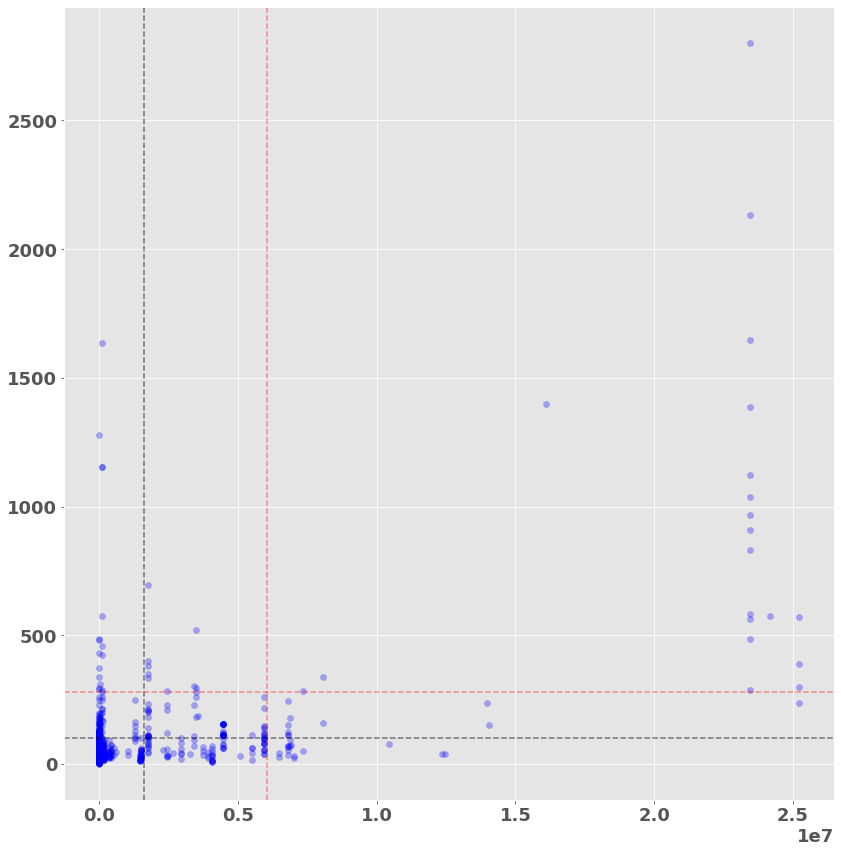

In [226]:
#International v case_rate
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
pop_mean = a1['pop_over_25'].mean()
plt.scatter(a1['international'], a1['case_rate'] , color = 'blue', label="actual data", alpha=0.3) 
plt.axhline(y=a1['case_rate'].mean(), color='black', linestyle='--', alpha=0.5)
plt.axvline(x=a1['international'].mean(), color='black', linestyle='--', alpha=0.5)
plt.axhline(y=a1['case_rate'].quantile(.95), color='r', linestyle='--', alpha=0.4)
plt.axvline(x=a1['international'].quantile(.95), color='r', linestyle='--', alpha=0.4)

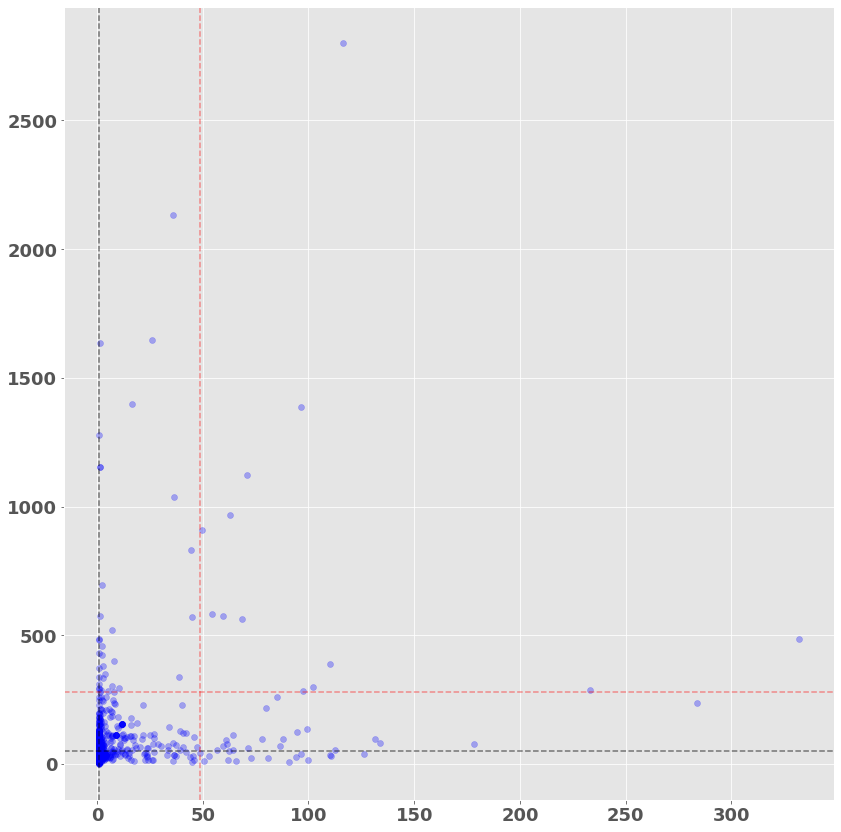

In [225]:
#International normed v case_rate
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
pop_mean = a1['pop_over_25'].mean()
plt.scatter(a1['intl_normed'], a1['case_rate'] , color = 'blue', label="actual data", alpha=0.3) 
plt.axhline(y=a1['case_rate'].median(), color='black', linestyle='--', alpha=0.5)
plt.axvline(x=a1['intl_normed'].median(), color='black', linestyle='--', alpha=0.5)
plt.axhline(y=a1['case_rate'].quantile(.94), color='r', linestyle='--', alpha=0.4)
plt.axvline(x=a1['intl_normed'].quantile(.94), color='r', linestyle='--', alpha=0.4)

3.3166247903554


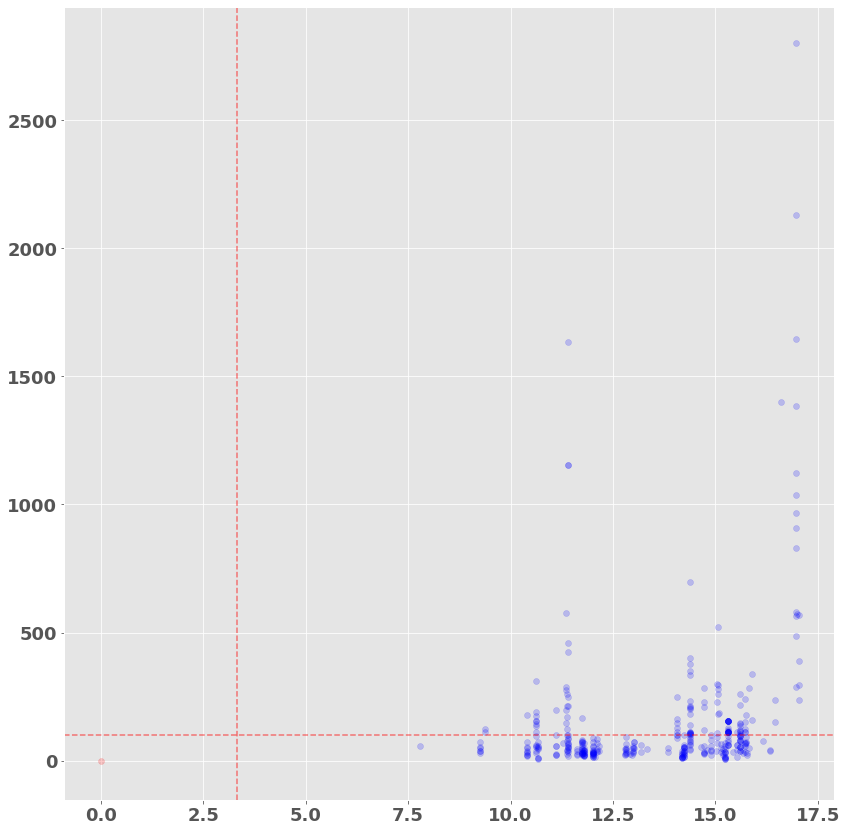

In [189]:
#with log scale on y
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
a1['international'] = a1['international'] + 1
international = a1['international'].apply(np.sqrt)
ase_rate = a1['case_rate']
plt.scatter(intl, case_rate , color = 'blue', label="actual data", alpha=0.2) 
plt.scatter([np.log(1)], [0] , color = 'red', label="actual data", alpha=0.2) 
plt.axhline(case_rate.mean(), color='r', linestyle='--', alpha=0.5)
plt.axvline(international.median(), color='r', linestyle='--', alpha=0.5)
print(international.quantile(0.5))


0.0


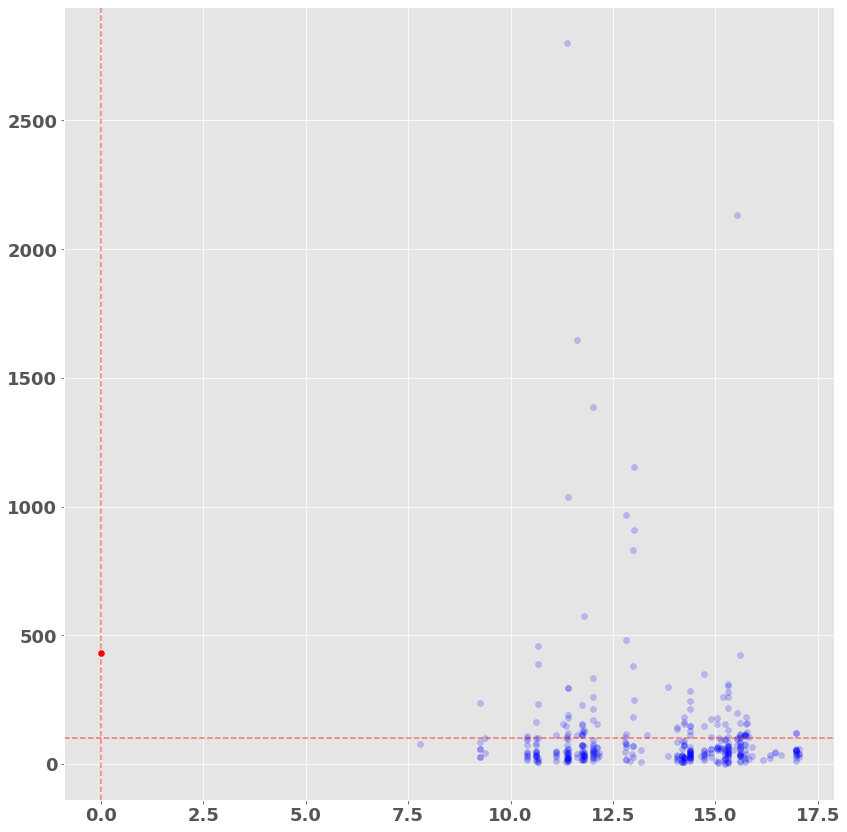

In [213]:
#with log scale on y
a1 = big_df.sort_values(by=['case_rate'], ascending=False)[['sc','pop_over_25', 'international', 'intl_normed', 'case_rate', 'death_rate', 'cases', 'deaths']]

fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
a1['intl_normed'] = a1['intl_normed'] + 1
international = a1['intl_normed'].apply(np.log)
ase_rate = a1['case_rate']
plt.scatter(intl, case_rate , color = 'blue', label="actual data", alpha=0.2) 
plt.scatter([np.log(1.000000)], [431.128575] , color = 'red', label="test", alpha=1) 
plt.axhline(case_rate.mean(), color='r', linestyle='--', alpha=0.5)
plt.axvline(international.median(), color='r', linestyle='--', alpha=0.5)
print(international.quantile(0.5))

In [212]:
a1

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.297669
24     0.000000
25     0.000000
26     0.003410
27     1.462630
28     0.000000
29     0.000000
30     0.000000
31     0.000000
32     0.000000
33     0.000000
34     0.000000
35     0.000000
36     0.000000
37     0.000000
38     0.000000
39     0.000000
40     0.000000
41     1.971880
42     0.000000
43     0.000000
44     0.000000
45     0.000000
46     0.000000
47     0.000000
48     0.000000
49     0.000000
50     3.616063
51     0.000000
52     0.000000
53     0.000000
54     4.287703
55     0.993566
56     1.900108
57     0.390194
58     0.112068
59     0.101865
60     0.000000
61     3.166487
62     0

In [208]:
a1[a1['intl_normed'] == 1]['case_rate']

132    1276.339980
427     485.173182
571     482.733012
239     431.128575
568     373.321373
592     338.582853
429     293.491706
25      291.379334
681     261.125313
735     248.920797
248     228.312769
22      197.907161
411     192.851902
241     181.698774
730     181.234579
408     179.194073
244     171.584169
238     166.710643
359     164.354560
428     163.992035
615     156.858189
400     155.244742
734     152.724934
723     150.900372
34      147.230763
341     136.652025
135     135.817730
209     133.577849
717     133.475707
157     131.821943
424     130.492752
563     126.955278
601     126.869564
566     126.859411
249     125.522058
550     123.824715
501     121.323232
9       120.836021
19      120.578778
583     120.440977
416     119.669243
599     119.307937
240     117.353566
722     116.690369
254     115.825267
210     115.013135
398     113.101970
412     111.536877
603     109.767763
188     107.864834
425     107.146527
343     106.726664
319     106.

In [201]:
a1

,sc,pop_over_25,international,intl_normed,case_rate,death_rate,cases,deaths
422,New York:Rockland,203545,23463764.0,116.275561,2801.837432,37.338181,5703,76
432,New York:Westchester,670570,23463764.0,35.990775,2131.470242,37.729096,14293,253
413,New York:Nassau,947754,23463764.0,25.757230,1647.684948,56.449247,15616,535
247,Louisiana:Orleans,279271,88687.0,1.317566,1634.612974,61.230847,4565,171
426,New York:Suffolk,1034154,16107904.0,16.575924,1399.501428,22.917283,14473,237
418,New York:Orange,245240,23463764.0,96.676741,1385.173707,20.795955,3397,51
132,Georgia:Dougherty,56568,0.0,1.000000,1276.339980,77.782492,722,44
242,Louisiana:Jefferson,306097,88687.0,1.289735,1153.229205,39.529953,3530,121
243,Louisiana:Jefferson,306097,88687.0,1.289735,1153.229205,39.529953,3530,121
387,New Jersey:Passaic,334793,23463764.0,71.084392,1121.887256,15.830677,3756,53
